In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def gen_mask(length, p, prob_func='constant'):
    """
    Call of prob_func gives 1 or 0 with certain probability.
    """
    mask_mat = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            if i >= j:
                val = 0
                r = np.random.uniform()
                prob = 0
                if prob_func == 'pn':
                    prob = p
                if prob_func == 'log':
                    prob = p * np.log(length) / length
                if prob_func == 'p':
                    prob = p / length
                if r <= prob:
                    val = 1
                mask_mat[i, j] = val
                mask_mat[j, i] = val
    return mask_mat


def get_spectrum(n, theta, mask):
    G = np.random.normal(size=(n, n))
    X = (G + np.transpose(G)) / (2*n)**0.5
    u = np.random.rand(n)
    u = u / np.linalg.norm(u)
    u = u[None, :]
    X_tilda = X + theta * u * u.transpose()
    X_bar = X_tilda * mask
    eigvals, eigvecs = np.linalg.eig(X_bar)
    idx = np.argmax(eigvals)
    max_eigvec = eigvecs[:, idx]
    inner_prod = np.inner(max_eigvec, u.reshape(-1))
    return sorted(eigvals), inner_prod

# Eigen-spectrum of $\bar{X}$

## d = p * n

The first thing I want to check is how p changes the spectrum. So I selected p from 0 to 1 and plotted the spectrums.

In [68]:
n = 100
theta = 100
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
eigvals_list = []
ip_list = []
for p in ps:
    mask = gen_mask(n, p, 'pn')
    eigvals, inner_prod = get_spectrum(n, theta, mask)
    eigvals_list.append(eigvals)
    ip_list.append(inner_prod)

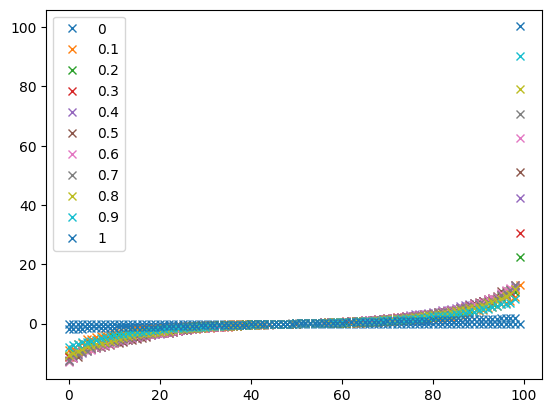

In [69]:
for i in range(len(ps)):
    plt.plot(eigvals_list[i], 'x', label=f'{ps[i]}')
plt.legend()
plt.show()

It seems like the largest eigenvalues is propotional to p. And the range of the other eigenvalues increases and then decreases. To check the first hypothesis, I plotted max(eigvalues) v.s. p.

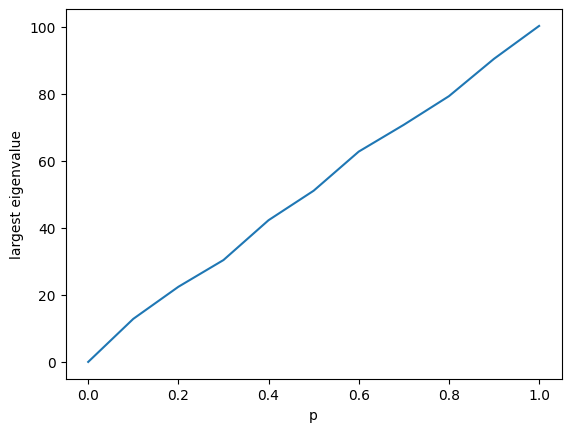

In [72]:
largest_eigvals = []
for eigvals in eigvals_list:
    largest_eigvals.append(np.max(eigvals))
plt.plot(ps, largest_eigvals)
plt.xlabel('p')
plt.ylabel('largest eigenvalue')
plt.show()

It looks like the largest eigenvalues are propotional to p. However, the curve is definitely not a straight line. I further checked whether these nonlinear parts are actually noise.

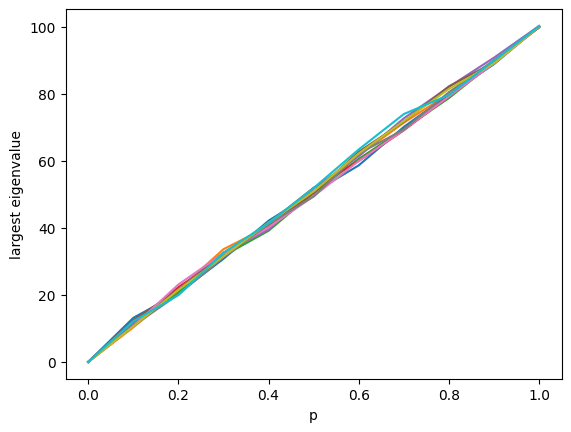

In [73]:
n = 100
theta = 100
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
trials = 10
for _ in range(trials):
    eigvals_list = []
    ip_list = []
    for p in ps:
        mask = gen_mask(n, p, 'pn')
        eigvals, inner_prod = get_spectrum(n, theta, mask)
        eigvals_list.append(eigvals)
        ip_list.append(inner_prod)
    largest_eigvals = []
    for eigvals in eigvals_list:
        largest_eigvals.append(np.max(eigvals))
    plt.plot(ps, largest_eigvals)
plt.xlabel('p')
plt.ylabel('largest eigenvalue')
plt.show()

How about the other two probability functions?

## d = p * log(n)

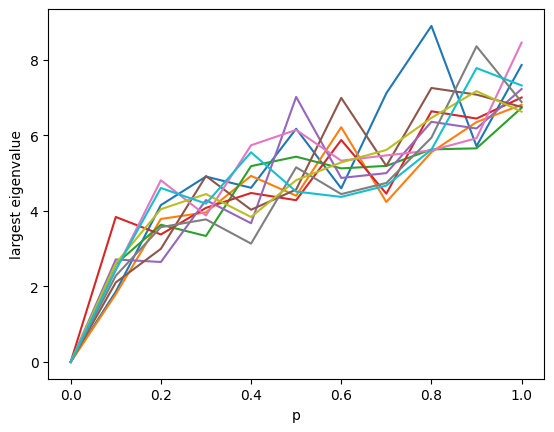

In [78]:
n = 100
theta = 100
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
trials = 10
for _ in range(trials):
    eigvals_list = []
    ip_list = []
    for p in ps:
        mask = gen_mask(n, p, 'log')
        eigvals, inner_prod = get_spectrum(n, theta, mask)
        eigvals_list.append(eigvals)
        ip_list.append(inner_prod)
    largest_eigvals = []
    for eigvals in eigvals_list:
        largest_eigvals.append(np.real(np.max(eigvals)))
    plt.plot(ps, largest_eigvals)
plt.xlabel('p')
plt.ylabel('largest eigenvalue')
plt.show()

Looks noisy. More trials and take mean value and larger n.

100%|██████████| 5/5 [03:00<00:00, 36.02s/it]


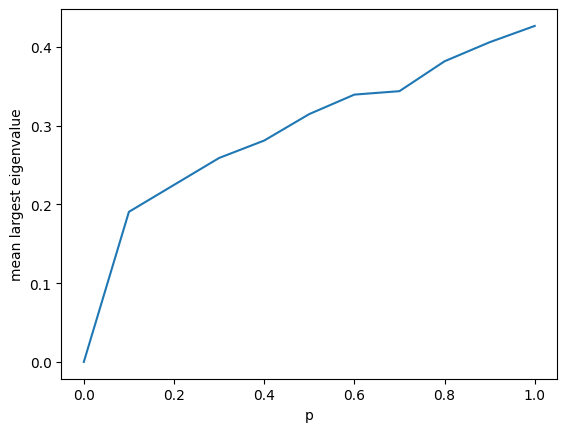

In [87]:
n = 1000
theta = 100
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
trials = 5

mean_largest_eigvals = np.zeros(len(ps))
for _ in tqdm(range(trials)):
    eigvals_list = []
    ip_list = []
    for p in ps:
        mask = gen_mask(n, p, 'log')
        eigvals, inner_prod = get_spectrum(n, theta, mask)
        eigvals_list.append(eigvals)
        ip_list.append(inner_prod)
    largest_eigvals = []
    for eigvals in eigvals_list:
        largest_eigvals.append(np.real(np.max(eigvals)))
    mean_largest_eigvals += np.array(largest_eigvals) / len(ps)
plt.plot(ps, mean_largest_eigvals)
plt.xlabel('p')
plt.ylabel('mean largest eigenvalue')
plt.show()

## d = p

100%|██████████| 5/5 [01:57<00:00, 23.46s/it]


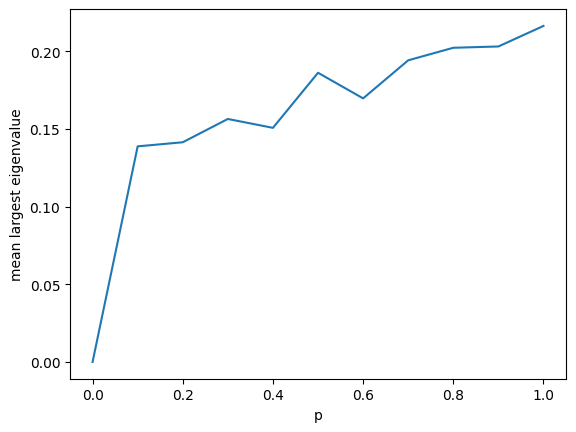

In [88]:
n = 1000
theta = 100
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
trials = 5

mean_largest_eigvals = np.zeros(len(ps))
for _ in tqdm(range(trials)):
    eigvals_list = []
    ip_list = []
    for p in ps:
        mask = gen_mask(n, p, 'p')
        eigvals, inner_prod = get_spectrum(n, theta, mask)
        eigvals_list.append(eigvals)
        ip_list.append(inner_prod)
    largest_eigvals = []
    for eigvals in eigvals_list:
        largest_eigvals.append(np.real(np.max(eigvals)))
    mean_largest_eigvals += np.array(largest_eigvals) / len(ps)
plt.plot(ps, mean_largest_eigvals)
plt.xlabel('p')
plt.ylabel('mean largest eigenvalue')
plt.show()

Still noisy. Is $\theta$ too small? Test with other values.

# Inner product between u and leading eigenvector of $\bar{X}$

## d = p * n

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:40<00:00,  2.26it/s]


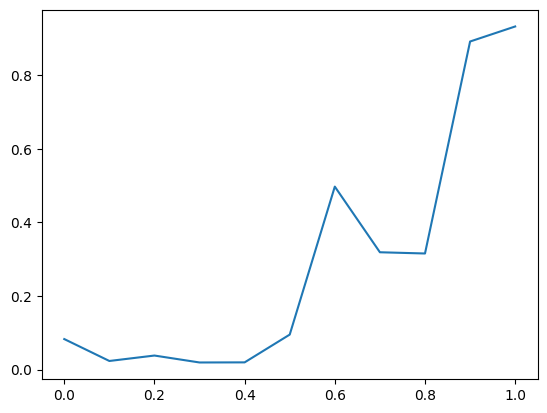

In [3]:
trials = 1000
n = 200
theta = 100
ps = np.linspace(0, 1, 30)
ips = np.zeros(len(ps))
for _ in tqdm(range(trials)):
    ip_list = []
    for p in ps:
        mask = gen_mask(n, p, 'pn')
        eigvals, inner_prod = get_spectrum(n, theta, mask)
        ip_list.append(inner_prod)
    ips += np.array(ip_list) / trials
plt.plot(ps, np.abs(ips))
plt.show()